In [1]:
import sys
sys.path.append('../centroFlye_repo/scripts')

import os
from collections import defaultdict, Counter
import statistics

import numpy as np
import edlib

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from utils.bio import read_bio_seq, write_bio_seqs
from ncrf_parser import NCRF_Report
from utils.os_utils import smart_mkdir
from eltr_polisher import read_reported_positions

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]


In [3]:
data_dir = os.path.join('..', 'data')
centroFlye_results_dir = os.path.join(data_dir, 'centroFlye_results')

read_placement_fn = \
os.path.join(centroFlye_results_dir, 'tr_resolution', 'read_positions.csv')

ncrf_fn = \
os.path.join(centroFlye_results_dir, 'NCRF', 'report.ncrf')

polished_dir = \
os.path.join(centroFlye_results_dir, 'polishing1')

dxz1_fn = \
os.path.join(centroFlye_results_dir, 'DXZ1_star', 'DXZ1_rc_star.fasta')

outdir = os.path.join(data_dir, 'abnormal_units')

centroFlye_assembly_fn = os.path.join(polished_dir, 'final_sequence_4.fasta')


In [4]:
smart_mkdir(outdir)

In [5]:
ncrf_report = NCRF_Report(ncrf_fn)

In [6]:
motif_alignments = ncrf_report.get_motif_alignments()

In [7]:
read_placement = read_reported_positions(read_placement_fn)

In [8]:
dxz1 = read_bio_seq(dxz1_fn)

# Distribution of lengths in cenX assembly

In [9]:
assembly_len = 1510
assembly_unit_lens = []
for pos in range(assembly_len):
    polished_unit_fn = os.path.join(polished_dir, f'pos_{pos}', 'polished_4.fasta')
    polished_unit = read_bio_seq(polished_unit_fn)
    assembly_unit_lens.append(len(polished_unit))

/home/abzikadze/miniconda3/envs/python3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


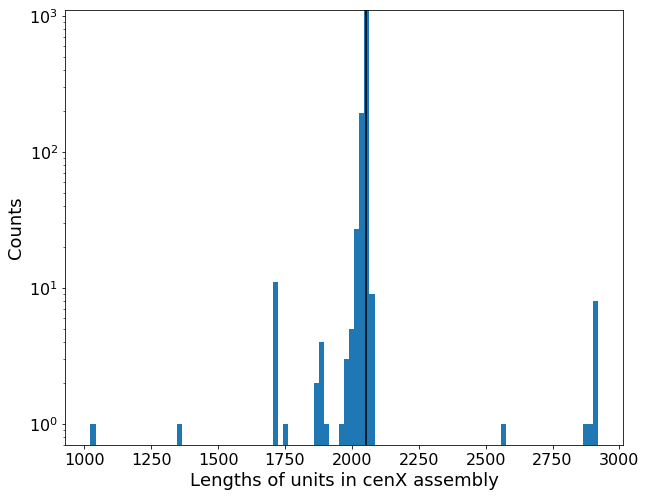

In [10]:
plt.hist(assembly_unit_lens, bins=100)
plt.vlines(len(dxz1), 0, 1100)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.xlabel('Lengths of units in cenX assembly', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.ylim((0, 1100))
pass

In [11]:
np.mean(assembly_unit_lens), np.median(assembly_unit_lens), np.std(assembly_unit_lens)

(2055.3251655629138, 2057.0, 84.414278568836266)

# Abnormal units

In [12]:
def map_pos2read(read_placement, motif_alignments):
    pos2read = defaultdict(list)
    for r_id, pos in read_placement.items():
        if pos is None:
            continue
        record = ncrf_report.records[r_id]
        ma = motif_alignments[r_id]
        for i in range(len(ma)):
            pos2read[pos + i].append((r_id, i))
    return pos2read


In [13]:
pos2read = map_pos2read(read_placement, motif_alignments)

In [14]:
def get_abnormal_units(pos2read, motif_alignments, unit_len=2055):
    all_r_units_lens = []
    med_lens = {}
    for pos in pos2read:
        seqs = {}
        median_read_unit, template_read = "", None
        for (r_id, p) in pos2read[pos]:
            r_al = motif_alignments[r_id][p].r_al
            r_al = r_al.upper().replace('-', '')
            seqs[f'gen_pos={pos}|r_id={r_id}|r_pos={p}'] = r_al
        r_units_lens = [len(seq) for seq in seqs.values()]
        all_r_units_lens += r_units_lens
        med_len = statistics.median_high(r_units_lens)
        med_lens[pos] = med_len
    
    all_med_len = statistics.median_high(all_r_units_lens)
    abnormal_units = {}
    for pos, med_len in med_lens.items():
        if med_len < 0.95 * all_med_len or med_len > 1.05 * all_med_len:
            abnormal_units[pos] = med_len
    return all_med_len, abnormal_units


In [15]:
all_med_len, abnormal_units = \
get_abnormal_units(pos2read, motif_alignments)


Abnormal units

In [16]:
print(abnormal_units.keys())

dict_keys([0, 117, 298, 332, 334, 338, 399, 544, 548, 564, 571, 576, 582, 624, 626, 640, 649, 669, 678, 697, 706, 947, 1173, 1177, 1185, 1197, 1199, 1201, 1203, 1215, 1218, 1347, 1350, 1484, 1509])


\# Abnormal units

In [17]:
len(abnormal_units)

35

Lengths of abnormal units

In [18]:
nmer_lens = []
for pos, length in abnormal_units.items():
    nmer_lens.append(round(length / 171))
    print(pos, nmer_lens[-1], length / 171)

0 8 7.964912280701754
117 10 9.988304093567251
298 11 10.853801169590643
332 11 10.736842105263158
334 15 14.801169590643275
338 17 16.730994152046783
399 17 16.678362573099417
544 17 16.789473684210527
548 17 16.801169590643276
564 17 16.830409356725145
571 17 16.70175438596491
576 17 16.736842105263158
582 17 16.625730994152047
624 10 9.947368421052632
626 10 9.929824561403509
640 11 10.88888888888889
649 11 10.88888888888889
669 11 10.91812865497076
678 11 10.912280701754385
697 11 10.941520467836257
706 10 9.970760233918128
947 6 5.988304093567251
1173 17 16.75438596491228
1177 17 16.77777777777778
1185 10 9.91812865497076
1197 10 9.953216374269006
1199 10 9.894736842105264
1201 10 9.95906432748538
1203 10 9.883040935672515
1215 10 9.912280701754385
1218 10 9.894736842105264
1347 5 4.690058479532164
1350 8 7.508771929824562
1484 11 11.017543859649123
1509 10 10.339181286549708


Most common lengths of abnormal units

In [19]:
Counter(nmer_lens).most_common()

[(10, 12), (17, 10), (11, 8), (8, 2), (15, 1), (6, 1), (5, 1)]

Generating dot plots of abnormal units

In [20]:
def get_gepard_cmd(seq1, seq2, outfile):
    cmd = 'java -cp /home/abzikadze/soft/gepard/dist/Gepard-1.40.jar ' + \
        'org.gepard.client.cmdline.CommandLine ' + \
        f'-seq1 {seq1} -seq2 {seq2} ' + \
        f'-matrix /home/abzikadze/soft/gepard/resources/matrices/edna.mat -outfile {outfile}'
    return cmd

In [21]:
for pos in abnormal_units:
    polished_unit_fn = os.path.join(polished_dir, f'pos_{pos}', 'polished_4.fasta')
    polished_unit = read_bio_seq(polished_unit_fn)
    polished_unit_for_gepard_fn = os.path.join(polished_dir, f'pos_{pos}', 'polished_4_gepard.fasta')
    write_bio_seqs(polished_unit_for_gepard_fn, {f'unit_{pos}': polished_unit})
    outfile = os.path.join(outdir, f'pos_{pos}.png')
    cmd = get_gepard_cmd(polished_unit_for_gepard_fn, dxz1_fn, outfile)
    !{cmd}

Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_0/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_117/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_298/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_332/polished_4_gepard.fasta


Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_1203/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_1215/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_1218/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_1347/polished_4_gepard.

# Abnormal 12-mers

Generation of abnormal 12-mers

In [22]:
def get_abnormal_12mers(indir, max_pos=1509, all_med_len=all_med_len):
    edit_distances = {}
    for pos in range(max_pos + 1):
        unit_fn = os.path.join(indir, f'pos_{pos}', 'polished_4.fasta')
        unit = read_bio_seq(unit_fn)
        if len(unit) < 0.93 * all_med_len or len(unit) > 1.07 * all_med_len:
            continue
        alignment = edlib.align(unit, dxz1, task='locations')
        #print(pos, alignment)
        edit_distances[pos] = alignment['editDistance']
    
    return edit_distances


In [23]:
edit_distances = get_abnormal_12mers(polished_dir)

In [24]:
outdir_12mers = os.path.join(data_dir, "abnormal_12_mers")
smart_mkdir(outdir_12mers)


In [25]:
for pos, ed in edit_distances.items():
    if ed > 100:
        polished_unit_fn = os.path.join(polished_dir, f'pos_{pos}', 'polished_4.fasta')
        polished_unit = read_bio_seq(polished_unit_fn)
        polished_unit_for_gepard_fn = os.path.join(polished_dir, f'pos_{pos}', 'polished_4_gepard.fasta')
        outfile = os.path.join(outdir_12mers, f'pos_{pos}.png')
        write_bio_seqs(polished_unit_for_gepard_fn, {f'unit_{pos}': polished_unit})
        cmd = get_gepard_cmd(polished_unit_for_gepard_fn, dxz1_fn, outfile)
        !{cmd}
        print(pos, ed)

Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_14/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
14 117
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_333/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
333 456
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_335/polished_4_gepard.fasta
Loading sequence from ../data/centroFlye_results/DXZ1_star/DXZ1_rc_star.fasta
Calculating suffix array... 
Calculating dotplot... 
Creating image and writing to file... 
335 166
Loading substitution matrix...
Loading sequence from ../data/centroFlye_results/polishing1/pos_439/

# Unique kmers in SVs

In [26]:
all_abnormal_units = sorted(list(abnormal_units.keys()) + [333, 335])

In [27]:
centroFlye_assembly = read_bio_seq(centroFlye_assembly_fn)

In [28]:
def get_unique_kmers(seq, k=19):
    all_kmers = defaultdict(int)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        all_kmers[kmer] += 1
    unique_kmers = set([k for k in all_kmers if all_kmers[k] == 1])
    return unique_kmers

In [29]:
unique_kmers = get_unique_kmers(centroFlye_assembly)

\# of unique kmers in each abnormal unit, including abnormal 12-mers

In [30]:
k=19
for pos in all_abnormal_units:
    unit_fn = os.path.join(polished_dir, f'pos_{pos}', 'polished_4.fasta')
    unit = read_bio_seq(unit_fn)
    unit_unique_kmers = get_unique_kmers(unit)
    print(pos, len(unit_unique_kmers & unique_kmers))

0 411
117 17
298 174
332 108
333 115
334 87
335 17
338 38
399 28
544 0
548 50
564 5
571 0
576 0
582 53
624 0
626 0
640 0
649 0
669 13
678 0
697 0
706 0
947 11
1173 6
1177 61
1185 47
1197 41
1199 0
1201 2
1203 5
1215 0
1218 0
1347 1221
1350 763
1484 83
1509 551
